# Классификация с использованием Наивного Байесовского Классификатора

## Осмотр данных


Открываем данные и смотрим на них.

In [229]:
import pandas as pd
df = pd.read_csv('/Users/roman/Desktop/Магистратура/Тервер/Задача 1-24/dataset_diseases.csv')
df.head()

,Test,Age_Group,Status
0,Positive,Young,Infected
1,Positive,Young,Infected
2,Positive,Young,Infected
3,Positive,Old,Infected
4,Positive,Old,Infected


In [231]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278 entries, 0 to 277
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Test       278 non-null    object
 1   Age_Group  278 non-null    object
 2   Status     278 non-null    object
dtypes: object(3)
memory usage: 6.6+ KB


In [233]:
df['Age_Group'].unique()

array(['Young', 'Old'], dtype=object)

In [235]:
df['Test'].unique()

array(['Positive', 'Negative'], dtype=object)

In [237]:
# рассчитываем частоты для классов
df.groupby('Status').count()

,Test,Age_Group
Status,,
Infected,142,142
Not_infected,136,136


In [239]:
df.groupby(['Status', 'Test']).count()

Age_Group
Status       Test               
Infected     Negative         52
             Positive         90
Not_infected Negative          8
             Positive        128

In [241]:
# визуализируем результат
df['Status'].value_counts(normalize=True)

Status
Infected        0.510791
Not_infected    0.489209
Name: proportion, dtype: float64

## Преобразуем данные

Предобработка данных и перевод их в векторный вид. Подгрузим необходимый модуль:

In [245]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

Заменим в данных все пустые строки и строки, состоящие из пробелов, на пропуски (NaN). После этого удалим из данных все строки, в которых наблюдаются пропущенные значения.

In [248]:
# Проверка на пропуски
df.isna().mean()

Test         0.0
Age_Group    0.0
Status       0.0
dtype: float64

In [250]:
# Замена целевой переменной на 1 и 0
df['Status'] = df['Status'].replace({'Infected': 1, 'Not_infected': 0}).astype(int)
df.sample(5)

/var/folders/3f/3ng7ys6906ngdc0rwxx8rxq00000gn/T/ipykernel_53887/472003492.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Status'] = df['Status'].replace({'Infected': 1, 'Not_infected': 0}).astype(int)


,Test,Age_Group,Status
242,Negative,Young,1
250,Positive,Old,0
156,Positive,Young,0
261,Positive,Old,0
15,Positive,Young,0


Переводим данные в векторный вид:

In [253]:
df['combined_text'] = df['Test'].astype(str) + ' ' + df['Age_Group'].astype(str)
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['combined_text'])

Определяем, сколько теперь признаков в нашем наборе данных:

In [256]:
print(X.shape)

(278, 4)


## Определяем целевую переменную и признаки

In [259]:
X = X
y = df['Status']

Разделим выборку на обучающую и тестовую, используя стратифицированное разбиение (параметр `stratify` установим в значение вектора ответов y), размер тестовой выборки (`test_size`) возьмем как 0.25, параметр `random_state` определим со значением 42:

In [262]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

Рассчитаем среднее значение целевой переменной:

In [268]:
round(y.mean(),3)

0.511

## Обучение

Определим и обучим подходящий алгоритм с параметром alpha = 0.01

In [272]:
clf = MultinomialNB(alpha=0.01)
clf.fit(X_train, y_train)

y_test_pred = clf.predict(X_test)

Оценим результат с точки зрения всех известных метрик:

In [274]:
acc  = accuracy_score(y_test, y_test_pred)
prec = precision_score(y_test, y_test_pred, pos_label = 1)
rec  = recall_score(y_test, y_test_pred, pos_label = 1)
f1   = f1_score(y_test, y_test_pred, pos_label = 1)

print(f"Accuracy : {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec:.3f}")
print(f"F1-score : {f1:.3f}")

Accuracy : 0.757
Precision: 0.806
Recall   : 0.694
F1-score : 0.746


Нарисуем ROC-кривую:

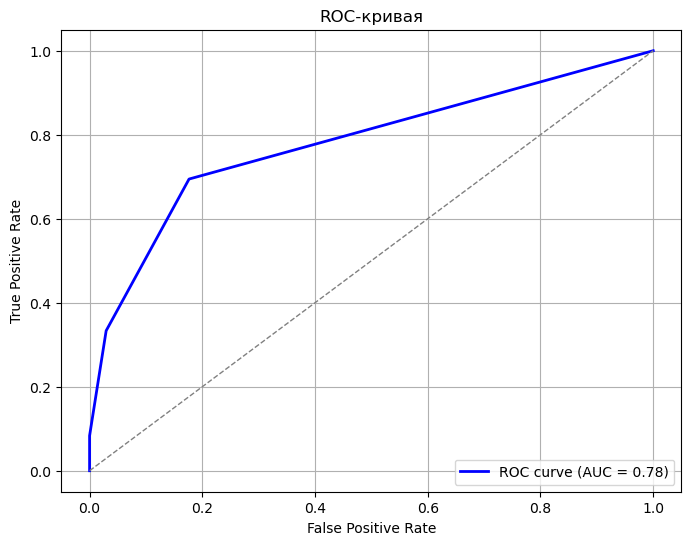

In [277]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_prob = clf.predict_proba(X_test)[:, 1]  # вероятности для положительного класса

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # случайный классификатор
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
